# Setup

### Activate inline plotting

In [45]:
%pylab inline
import sys
sys.path.insert(0, '../modules')
import numpy as np
import math

Populating the interactive namespace from numpy and matplotlib


### Import Dataset(s)

In [46]:
from root_numpy import root2array
from data import AlCapROOT

In [47]:
def get_energy_loss(initial_energy, mass_energy_2, hits):
    """ 
    Return the energy loss of the hit
    """
    energies = hits['M_e']
    # Remove from the initial energy to plot energy loss
    energies = numpy.absolute(np.square(energies) - mass_energy_2) 
    energies = np.sqrt(energies.astype(float))
    energies = (initial_energy - energies)/initial_energy
    return energies

In [48]:
hits_array = np.zeros(10)
index = 1
first_hit = 2
evt_n_hits = 2
hits_array[index:index+evt_n_hits] = range(first_hit, first_hit + evt_n_hits)
print hits_array

[ 0.  2.  3.  0.  0.  0.  0.  0.  0.  0.]


In [49]:
# List the relevant output files
#energies = ['05','1','2','4','6','8','10','12']
energies = ['1','2','3','4','5','6','7','8','9','10','11','12']
#energies = ['12']

# Define bins
this_bins = 20
this_range = [0,1.]


dummy = np.zeros(this_bins)
# Define the group of histograms, with first row as the bin_centers
energy_histograms = np.dstack([dummy,dummy,dummy])
counts_in_lqsc = np.zeros((len(energies),2))

for eng_id, energy in enumerate(energies):
    print "Processing " + energy + " MeV data"
    # Initialize the class
    neutrons = AlCapROOT(path='../data/40_cm_LYSO/neutrons_'+energy+'MeV_10e6_uniform.root',\
                         branches=["M_volName","M_e", "M_particleName"])
    mass_energy_2 =  0.939565378**2
    initial_energy = float(eng_id +1)/1000
    print initial_energy
   
    ## COUNTING HOW MANY NEUTRONS SCATTERED OFF OF LYSO AND HIT LIQUID SCINTILLATOR ##

    # Get all the neutron hits
    neutron_hits = np.where(neutrons.hits_data["M_particleName"] == "neutron")[0]
    # Get the hits in the liquid scintillators that pass through side
    # facing the target that are also hit the lyso
    lqsc_left_hits = np.where(neutrons.hits_data[neutron_hits]["M_volName"] == "LiquidSc_Left_Face")
    lqsc_right_hits = np.where(neutrons.hits_data[neutron_hits]["M_volName"] == "LiquidSc_Right_Face")
    lqsc_hits = numpy.append(lqsc_left_hits, lqsc_right_hits)
   
    # Get neutrons that hit the lqsc
    lqsc_neutron_hits = neutron_hits[lqsc_hits]

    # Get the event ID's of these hits
    events_neutron_on_lqsc = neutrons.hits_to_entries[lqsc_neutron_hits]
    events_neutron_on_lqsc = np.unique(events_neutron_on_lqsc)

    # Get the all the hits from these events
    hits_from_neut_lqsc = neutrons.get_event_to_hits(events_neutron_on_lqsc)
    
    # Take only the neutron hits here
    neutron_hits = np.intersect1d(hits_from_neut_lqsc, neutron_hits)
    
    # Get neutrons that hit the lyso
    lyso_hits = np.where(neutrons.hits_data[neutron_hits]["M_volName"] == "LYSO")
    lyso_neutron_hits = neutron_hits[lyso_hits]

    # Get the event ID's of where neutron hit lyso
    events_on_both = neutrons.hits_to_entries[lyso_neutron_hits]
    events_on_both = np.unique(events_on_both)


    # Check which events had neutrons that hit both
    # events_on_both = numpy.intersect1d(events_neutron_on_lqsc, events_neutron_on_lyso)

    # Remove events that hit the LqSc first
    first_hits = []
    for event in events_on_both.astype(int):
        hits = neutrons.get_event_to_hits([event])
        lqsc_hit_R = np.where(neutrons.hits_data[hits]["M_volName"] == "LiquidSc_Right_Face")[0]
        lqsc_hit_L = np.where(neutrons.hits_data[hits]["M_volName"] == "LiquidSc_Left_Face")[0]
        lqsc_hit = np.append(lqsc_hit_L, lqsc_hit_R)
        lqsc_hit = min(lqsc_hit)
        lyso_hit = np.where(neutrons.hits_data[hits]["M_volName"] == "LYSO")[0][0]
        if lqsc_hit > lyso_hit:
            first_hits.append(lqsc_hit+neutrons.entry_to_hits[event])
 
    # Only use the events where the LYSO is hit first
    hits_with_lyso_first = numpy.array(first_hits)
    
    # Record total neutron hits on lsqc and number that hit both
    counts_in_lqsc[eng_id,0] = len(events_neutron_on_lqsc)
    counts_in_lqsc[eng_id,1] = len(hits_with_lyso_first)
    
    ## FINDING THE CHANGE IN THE ENERGY DISTRIBUTION FROM LYSO-RESCATTERED ##
    ## NEUTRONS ON LQSC NEUTRON ENERGY DISTRIBUTION                        ##
        
    # Get the energy distribtuion of the neutrons that hit the LYSO
    lqsc_energies = get_energy_loss(initial_energy, mass_energy_2,\
                                    neutrons.hits_data[lqsc_neutron_hits])
    # Histogram these values
    energy_hist, energy_bins = np.histogram(lqsc_energies, bins=this_bins, range=this_range) 

    # Get the energy distribution from these hits using the same binning as before
    both_energies = get_energy_loss(initial_energy, mass_energy_2,\
                                    neutrons.hits_data[hits_with_lyso_first])
    # Bin this information
    pollution_hist, ___ = np.histogram(both_energies, bins=this_bins,\
                                       range=this_range)

    # Stack the binning used, the energy histogram, and the pollution histogram
    these_hists = np.dstack([energy_bins[:-1],energy_hist,pollution_hist])
    # Add these three to the values currently stored
    energy_histograms = numpy.vstack([energy_histograms,these_hists])
    del neutrons

Processing 1 MeV data
0.001
Processing 2 MeV data
0.002
Processing 3 MeV data
0.003
Processing 4 MeV data
0.004
Processing 5 MeV data
0.005
Processing 6 MeV data
0.006
Processing 7 MeV data
0.007
Processing 8 MeV data
0.008
Processing 9 MeV data
0.009
Processing 10 MeV data
0.01
Processing 11 MeV data
0.011
Processing 12 MeV data
0.012


In [261]:
# Plotting options
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size=15)

(13, 20, 3)


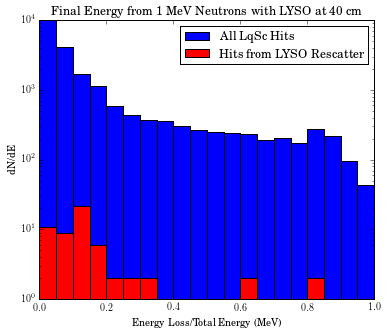

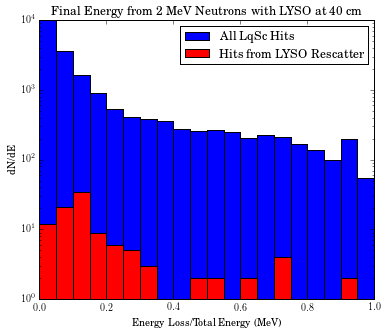

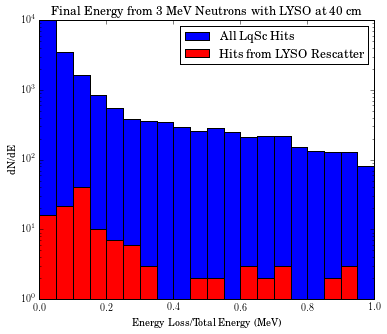

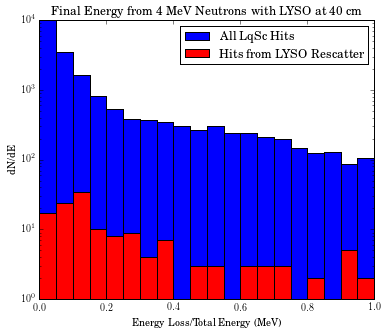

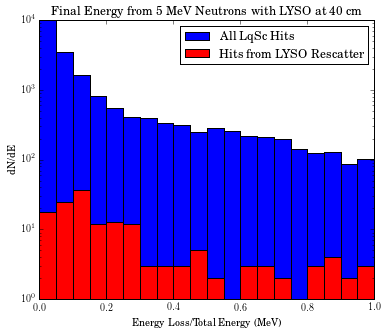

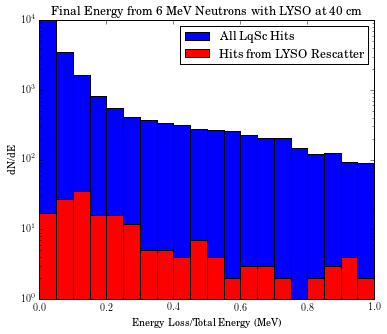

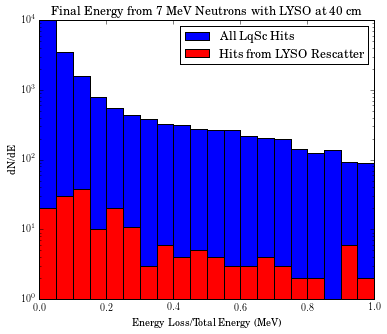

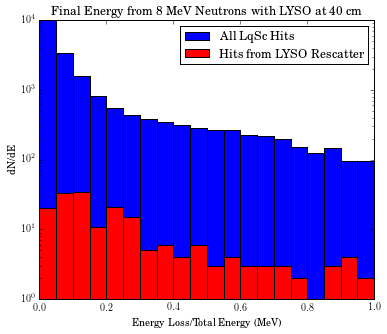

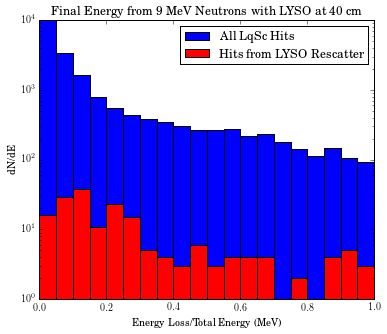

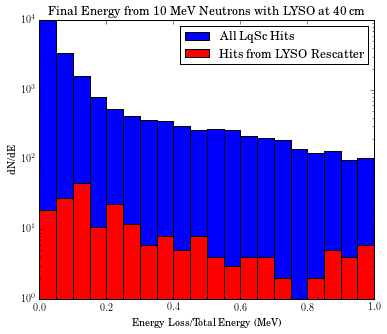

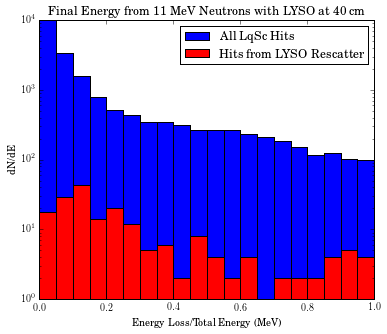

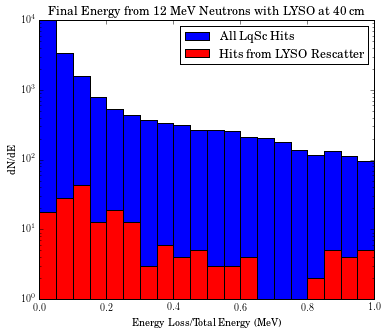

In [252]:
print energy_histograms.shape
for energy_value in range(1,13):
    left_bins = energy_histograms[energy_value,:,0].copy()
    total_values = energy_histograms[energy_value,:,1]
    polution_values = energy_histograms[energy_value,:,2]
    d_bin = left_bins[1] - left_bins[0]

    plt.bar(left_bins,total_values,width=d_bin, label='All LqSc Hits', log=True)
    plt.bar(left_bins,polution_values,width=d_bin, color='red', label='Hits from LYSO Rescatter')
    plt.legend(loc=0)
    plt.title("Final Energy from {} MeV Neutrons with LYSO at 40 cm".format(energy_value))
    plt.ylim(0,10000)
    plt.xlim(left_bins[0],left_bins[-1]+d_bin)
    plt.xlabel('Energy Loss/Total Energy (MeV)')
    plt.ylabel('dN/dE')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    savefig("final_energy_{}MeV_neutrons_LYSO_40cm".format(energy_value))
    show()



(12, 2)


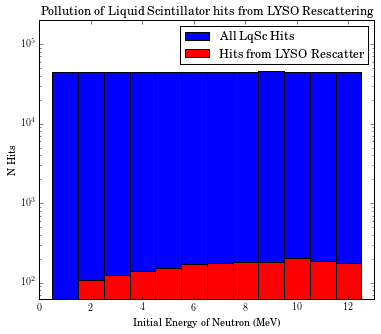

In [253]:
print counts_in_lqsc.shape
ratio = counts_in_lqsc[:,1]/counts_in_lqsc[:,0].astype(float) 
plt.bar([n+0.5 for n in range(12)],counts_in_lqsc[:,0], width=1, log=True, label='All LqSc Hits')
plt.bar([n+0.5 for n in range(12)],counts_in_lqsc[:,1], width=1, color='red', label='Hits from LYSO Rescatter')
plt.title("Pollution of Liquid Scintillator hits from LYSO Rescattering".format(energy_value))
plt.xlim(0,13)
plt.ylim(0,200000)
plt.xlabel("Initial Energy of Neutron (MeV)")
plt.ylabel('N Hits')
plt.legend(loc=0)
savefig("raw_hit_count_comparison_rescatter_LYSO_40cm".format(energy_value))

show()


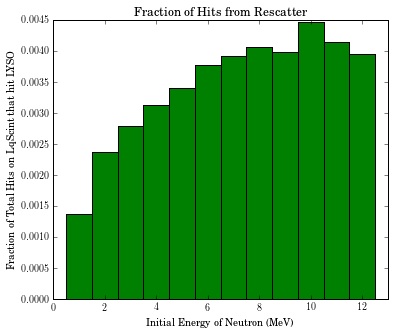

In [254]:
plt.bar([n+0.5 for n in range(12)], ratio, width=1.,color='green')
plt.title("Fraction of Hits from Rescatter")
plt.xlim(0,13)
plt.xlabel("Initial Energy of Neutron (MeV)")
plt.ylabel('Fraction of Total Hits on LqScint that hit LYSO')
savefig("relative_comparison_rescatter_LYSO_40cm".format(energy_value))


In [53]:
print counts_in_lqsc

[[ 44932.     62.]
 [ 45017.    107.]
 [ 45076.    126.]
 [ 45092.    141.]
 [ 45259.    154.]
 [ 45217.    171.]
 [ 45178.    177.]
 [ 45216.    184.]
 [ 45329.    181.]
 [ 45239.    202.]
 [ 45241.    188.]
 [ 45215.    179.]]


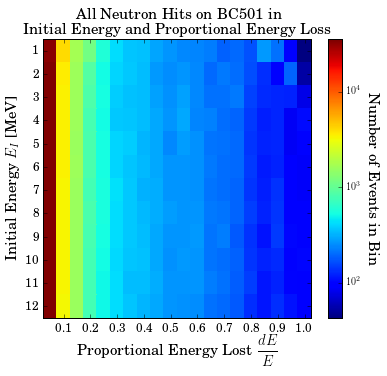

In [257]:
figsize(6,5)
#data
data = np.vstack([energy_histograms[i+1,:,1] for i in range(energy_histograms.shape[0]-1)])
fig, ax = plt.subplots()
heatmap = ax.pcolor(data,norm=matplotlib.colors.LogNorm())

#legend
cbar = plt.colorbar(heatmap)
ticks = cbar.ax.get_yticks()
data = np.log10(data+1)
heatmap = ax.pcolor(data)
cbar.ax.set_yticks(ticks,fontsize=12)
cbar.set_label('Number of Events in Bin', rotation=270, labelpad=20, fontsize=15)

# put the major ticks at the middle of each cell
x_ticks = np.arange(data.shape[1])[::2]
ax.set_xticks(np.arange(data.shape[1])[1::2] + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
ax.set_ylabel( r"Initial Energy $E_{I}$ [MeV]", fontsize=15) 

ax.set_xlabel(r"Proportional Energy Lost $\displaystyle\frac{dE}{E}$", fontsize=15)
ax.set_title("All Neutron Hits on BC501 in\n"+\
             "Initial Energy and Proportional Energy Loss", fontsize=15)
ax.invert_yaxis()

#lebels
column_labels = range(20)
column_labels = [i*0.1 for i in range(1,11)]
row_labels = range(1,13)
ax.set_xticklabels(column_labels, minor=False,fontsize=12)
ax.set_yticklabels(row_labels, minor=False,fontsize=12)
savefig("all_neutrons_initial_e_prop_e_loss")


plt.show()

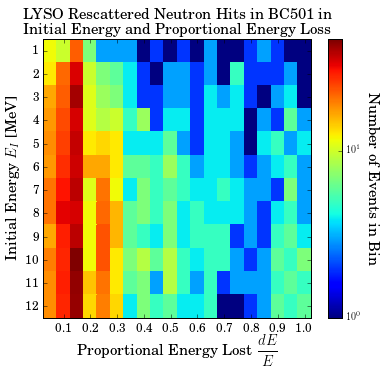

In [258]:
figsize(6,5)
#data
data = np.vstack([energy_histograms[i+1,:,2] for i in range(energy_histograms.shape[0]-1)])
fig, ax = plt.subplots()
heatmap = ax.pcolor(data,norm=matplotlib.colors.LogNorm())

#legend
cbar = plt.colorbar(heatmap)
ticks = cbar.ax.get_yticks()
data = np.log10(data+1)
heatmap = ax.pcolor(data)
cbar.ax.set_yticks(ticks,fontsize=12)
cbar.set_label('Number of Events in Bin', rotation=270, labelpad=20, fontsize=15)

# put the major ticks at the middle of each cell
x_ticks = np.arange(data.shape[1])[::2]
ax.set_xticks(np.arange(data.shape[1])[1::2] + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
ax.set_ylabel( r"Initial Energy $E_{I}$ [MeV]", fontsize=15) 

ax.set_xlabel(r"Proportional Energy Lost $\displaystyle\frac{dE}{E}$", fontsize=15)
ax.set_title("LYSO Rescattered Neutron Hits in BC501 in\n"+\
             "Initial Energy and Proportional Energy Loss", fontsize=15)
ax.invert_yaxis()

#lebels
column_labels = range(20)
column_labels = [i*0.1 for i in range(1,11)]
row_labels = range(1,13)
ax.set_xticklabels(column_labels, minor=False,fontsize=12)
ax.set_yticklabels(row_labels, minor=False,fontsize=12)
savefig("recatter_initial_e_prop_e_loss")

plt.show()